In [1]:
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

In [3]:
def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

In [4]:
def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

In [5]:
def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2, y_pred

In [6]:
def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

In [7]:
def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

In [8]:
def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

In [54]:
def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(r2_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(r2_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./Linear_AD.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

In [55]:
# Load Data Train csv
train = pickle.load(open('Train_Test/train_bams.p','rb'))
test = pickle.load(open('Train_Test/test_bams.p','rb'))
train.shape, test.shape

((107, 1876), (27, 1876))

# SVR_RBF

In [11]:
# Load Pickle rbf
params = pickle.load(open("data_RBF/params_rbf_5.p", "rb"))

label_5 = pickle.load(open("desc/desc5.pkl", "rb"))
x_train = train.loc[:,label_5].to_numpy()
x_test = test.loc[:,label_5].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax rbf
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'rbf', C = params['C'],
           gamma = params['gamma'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [12]:
train_rbf = q2_loo(model, sc_x_train, y_train)
train_rbf

(array([0.61178755]),
 [6.823003464782159,
  5.766423788149169,
  6.403746640008736,
  6.974521759741431,
  5.682232910047658,
  7.960552044100694,
  6.6270216725339885,
  8.178186289798932,
  5.482914814794611,
  6.600922059497857,
  8.331088876914574,
  6.770317281728689,
  7.536189287299495,
  7.670519653700551,
  7.667862712431935,
  5.703446696893144,
  6.583578567942511,
  5.15981233357956,
  5.381021254880782,
  8.42421375678748,
  7.714898909376267,
  9.057222084858356,
  7.193143698926139,
  6.856719676976261,
  8.02350768983063,
  6.772996318926622,
  5.57617315907835,
  8.029127166016615,
  6.8879850791208295,
  5.7698239471504635,
  6.516277894701137,
  5.855878774887893,
  5.776219170584163,
  5.6116934425225296,
  6.174619140200376,
  6.368254221820511,
  6.586087601572769,
  6.566213077995358,
  6.507607808609067,
  5.997251075830473,
  5.3297689525792675,
  5.436743710598863,
  6.388590013033414,
  6.235842974903979,
  6.6719971217198015,
  6.166035646177614,
  5.429570

In [13]:
train_rbf_r2 = r2_score(y_train, train_rbf[1])
train_rbf_r2

array([0.61178755])

In [14]:
y_test.shape, len(model.predict(x_test))

((27, 1), 27)

In [15]:
test_pred = model.predict(sc_x_test)
test_pred

array([5.45882878, 5.83905425, 5.62277371, 6.15874828, 7.82256147,
       6.68324237, 6.8244921 , 5.4525474 , 6.58012585, 5.45853249,
       5.61646173, 6.86217486, 7.85010723, 6.73801964, 5.3864816 ,
       4.8338211 , 8.10729127, 5.70848824, 6.11166131, 6.58645399,
       6.33212186, 8.8666608 , 6.61932682, 6.75713528, 6.82092426,
       8.70510523, 5.49197087])

In [16]:
rbf_qsar = qsar_param(y_train, train_rbf[1], d_r2m=True)
rbf_qsar

{'r2': array([0.61379343]),
 'k': 1.0715733543070443,
 'k_dash': 0.8196642231681232,
 'r2r0': array([0.01489382]),
 'r2r0_dash': array([0.12591776]),
 'r0r0_dash': array([0.06814577]),
 'rm2_bar': array([0.49913109]),
 'd_rm2': array([0.11195218])}

In [17]:
rbf_qsar = qsar_param(y_test, test_pred, d_r2m=True)
rbf_qsar

{'r2': array([0.72359676]),
 'k': 1.1696592208298409,
 'k_dash': 0.7822102339024127,
 'r2r0': array([0.00806718]),
 'r2r0_dash': array([0.04366462]),
 'r0r0_dash': array([0.02575819]),
 'rm2_bar': array([0.63164417]),
 'd_rm2': array([0.07333558])}

In [18]:
rbf_y = y_random(model, sc_x_train, y_train, n=10)
rbf_y

array([0.66239613])

0.16822429906542055


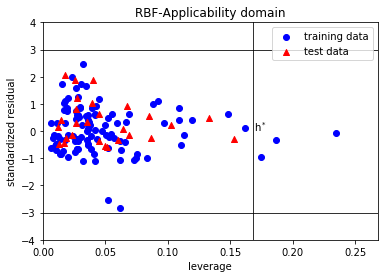

In [50]:
plt.title('RBF-Applicability domain')
rbf_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_rbf[1], y_test, test_pred)
rbf_AD

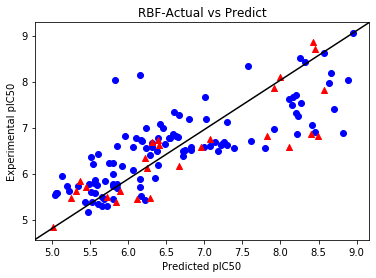

In [20]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_rbf[1], c='b',marker='o', label='training data')
ax.scatter(y_test, test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('RBF-Actual vs Predict')
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('./rbf_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

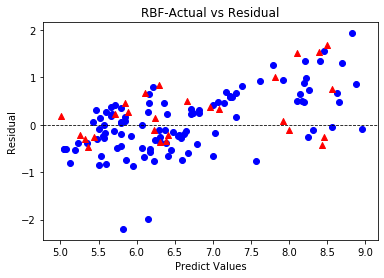

In [21]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_rbf[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(test_pred).to_numpy()

train = r_train-r_train_pred
test = r_test-r_test_pred
plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, train, c='b',marker='o', label='training data')
plt.scatter(r_test, test, c='r',marker='^', label='test data')
plt.title("RBF-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('./rbf_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")

# SVR_Poly

In [25]:
# Load Pickle poly
params = pickle.load(open("data_Poly/params_poly_5.p", "rb"))

poly_desc5 = pickle.load(open("desc/desc5.pkl", "rb"))
x_train = train.loc[:,poly_desc5].to_numpy()
x_test = test.loc[:,poly_desc5].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax poly
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'poly', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
train_q2_poly = q2_loo(model, sc_x_train, y_train)
train_q2_poly

(array([0.38486385]),
 [6.633437244778444,
  4.194183061461689,
  6.7655864056367285,
  7.22886675823505,
  5.82786580495711,
  7.101289841971062,
  7.006059818012972,
  7.300938387147781,
  5.625926263805565,
  7.145644900600121,
  7.123711945392722,
  6.761042346909762,
  7.352905555155641,
  7.423675346779683,
  7.944035356922889,
  5.852049282093183,
  6.62231859377645,
  6.550803756692004,
  5.668890404092359,
  8.267550462693912,
  7.183277854130904,
  7.906613921730189,
  6.950471475106545,
  7.20470878167862,
  6.823938143439002,
  6.926140050591162,
  5.482709673605462,
  8.084671763586938,
  7.008312877114788,
  5.738679104943772,
  5.920128705306765,
  6.0310537042940675,
  6.514700701497362,
  5.6103890598202195,
  7.0848571991074545,
  6.631200234023681,
  6.9243412177172186,
  6.862399747412172,
  6.706407675131667,
  6.122265707309904,
  5.758657751049072,
  5.606230127245341,
  5.718447801619267,
  6.645503334535781,
  6.935603458646693,
  6.652001261830293,
  6.1016049

In [27]:
poly = r2_score(y_train, train_q2_poly[1])
poly

array([0.38486385])

In [28]:
poly_test_pred = model.predict(sc_x_test)
poly_test_pred

array([5.1719075 , 6.19845911, 6.00257448, 6.31087289, 7.37450063,
       6.95645508, 6.99623613, 5.78146832, 6.15471003, 5.52007184,
       5.86695011, 7.52218772, 6.9984066 , 7.00790814, 6.96915543,
       6.76609502, 7.29984837, 6.11928493, 6.62412941, 7.05158648,
       6.63775403, 7.50659398, 6.73480039, 6.89416656, 7.04625861,
       6.94901073, 5.79011786])

In [29]:
poly_qsar = qsar_param(y_train, train_q2_poly[1], d_r2m=True)
poly_qsar

{'r2': array([0.38938789]),
 'k': 0.6826250740490041,
 'k_dash': 1.170872621491547,
 'r2r0': array([0.10694031]),
 'r2r0_dash': array([5.76622684]),
 'r0r0_dash': array([2.20365765]),
 'rm2_bar': array([0.05792261]),
 'd_rm2': array([0.5040121])}

In [30]:
poly_qsar = qsar_param(y_test, poly_test_pred, d_r2m=True)
poly_qsar

{'r2': array([0.52134407]),
 'k': 0.824772655963764,
 'k_dash': 1.0361842564604624,
 'r2r0': array([0.00696224]),
 'r2r0_dash': array([0.86042946]),
 'r0r0_dash': array([0.44495007]),
 'rm2_bar': array([0.33105135]),
 'd_rm2': array([0.31776641])}

In [31]:
poly_y = y_random(model, sc_x_train, y_train, n=10)
poly_y

array([0.41437312])

0.16822429906542055


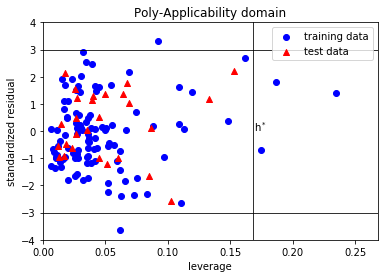

In [53]:
plt.title('Poly-Applicability domain')
poly_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_q2_poly[1], y_test, poly_test_pred)
poly_AD

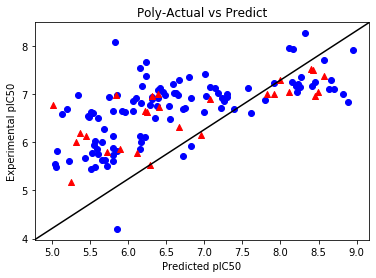

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_q2_poly[1], c='b',marker='o', label='training data')
ax.scatter(y_test, poly_test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('Poly-Actual vs Predict')
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('./poly_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

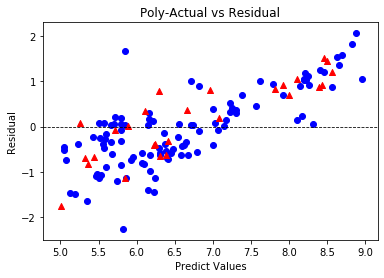

In [34]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_q2_poly[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(poly_test_pred).to_numpy()

p_train = r_train-r_train_pred
p_test = r_test-r_test_pred

plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, p_train, c='b',marker='o', label='training data')
plt.scatter(r_test, p_test, c='r',marker='^', label='test data')
plt.title("Poly-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('./poly_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")

# SVR_Linear

In [38]:
# Load Pickle linear
params = pickle.load(open("data_Linear/params_linear_5.p", "rb"))

linear_desc5 = pickle.load(open("desc/desc5.pkl", "rb"))
x_train = train.loc[:,linear_desc5].to_numpy()
x_test = test.loc[:,linear_desc5].to_numpy()
y_train = train.iloc[:,[-1]].to_numpy()
y_test = test.iloc[:,[-1]].to_numpy()

# minmax linear
mmscaler = MinMaxScaler()
mmscaler.fit(x_train)
sc_x_train = mmscaler.transform(x_train)
sc_x_test = mmscaler.transform(x_test)

# model
model = SVR(kernel = 'linear', C = params['C'],
           degree = params['degree'],
           epsilon = params['epsilon'])
model.fit(sc_x_train, y_train)


SVR(C=100, cache_size=200, coef0=0.0, degree=1, epsilon=1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [39]:
train_q2_linear = q2_loo(model, sc_x_train, y_train)
train_q2_linear

(array([0.32362676]),
 [6.791746222803219,
  4.627210657226088,
  6.918520915514783,
  7.155976467907401,
  5.809417969668566,
  6.620344965940959,
  7.0626184906207286,
  7.164572368747248,
  6.025239200736614,
  7.315919296579487,
  7.086501412130552,
  6.9926979087963375,
  7.13458460748319,
  7.132546213303151,
  7.971432712112637,
  5.8930812667124925,
  6.916649398193776,
  6.725171628334517,
  5.7358421716478105,
  7.646453925970653,
  7.305566160074811,
  7.599963787902033,
  6.733781288416644,
  7.315782032718026,
  6.970959366299108,
  6.953791315648196,
  5.882929956193429,
  7.8281867542388115,
  7.088899604053246,
  6.00197557713323,
  5.888188222968374,
  5.8730887089994255,
  6.68757537012274,
  5.574756033653095,
  7.075746390654636,
  6.89212338015448,
  7.014445772611417,
  7.106747199598517,
  6.915162767024462,
  5.932333202517604,
  6.061206056632976,
  5.674566211325235,
  5.6621921444455126,
  6.881816629456693,
  7.058712642936364,
  6.505345827417749,
  6.28019

In [40]:
linear = r2_score(y_train, train_q2_linear[1])
linear

array([0.32362676])

In [41]:
linear_test_pred = model.predict(sc_x_test)
linear_test_pred

array([4.9934541 , 5.70035701, 6.31560665, 6.37462835, 7.28970961,
       7.08676104, 7.16855749, 5.96822773, 5.94873256, 5.77671204,
       5.65256162, 7.49373014, 7.03651254, 7.0955346 , 7.10082774,
       6.47514236, 7.36692841, 6.39937274, 6.7672679 , 7.1385876 ,
       6.5532181 , 7.52712553, 6.97544303, 6.94261024, 7.0965232 ,
       7.20049491, 5.98549223])

In [42]:
linear_qsar = qsar_param(y_train, train_q2_linear[1], d_r2m=True)
linear_qsar

{'r2': array([0.33042854]),
 'k': 0.6638339551233166,
 'k_dash': 1.1906221040611535,
 'r2r0': array([0.03502723]),
 'r2r0_dash': array([5.2863079]),
 'r0r0_dash': array([1.735173]),
 'rm2_bar': array([0.09429967]),
 'd_rm2': array([0.40116108])}

In [43]:
linear_qsar = qsar_param(y_test, linear_test_pred, d_r2m=True)
linear_qsar

{'r2': array([0.5232266]),
 'k': 0.7786497328985011,
 'k_dash': 1.09460836318302,
 'r2r0': array([0.02511701]),
 'r2r0_dash': array([1.18720204]),
 'r0r0_dash': array([0.6080338]),
 'rm2_bar': array([0.28704602]),
 'd_rm2': array([0.35239778])}

In [44]:
linear_y = y_random(model, sc_x_train, y_train, n=10)
linear_y

array([0.36676967])

0.16822429906542055


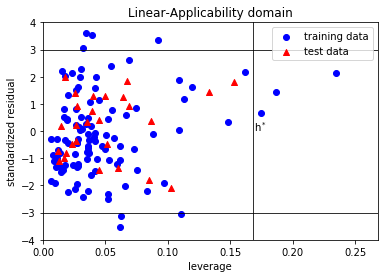

In [56]:
plt.title('Linear-Applicability domain')
linear_AD = applicability_domain(sc_x_train, sc_x_test, y_train, train_q2_linear[1], y_test, linear_test_pred)
linear_AD

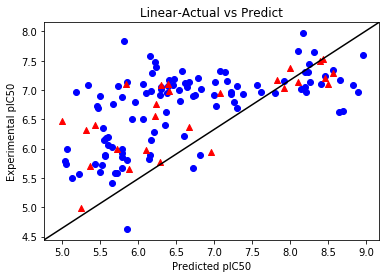

In [46]:
fig, ax = plt.subplots()
ax.scatter(y_train, train_q2_linear[1], c='b',marker='o', label='training data')
ax.scatter(y_test, linear_test_pred, c='r',marker='^', label='test data')
ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
plt.title('Linear-Actual vs Predict')
ax.set_xlabel('Predicted pIC50')
ax.set_ylabel('Experimental pIC50')
plt.savefig('./linear_Actual vs Predict.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

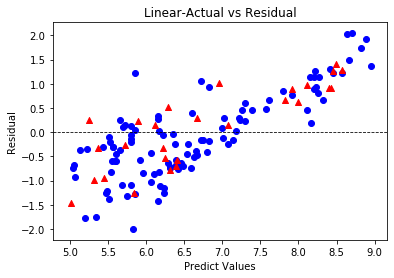

In [47]:
#dataframe to list
r_train = pd.DataFrame(y_train).to_numpy()
r_train_pred = pd.DataFrame(train_q2_linear[1]).to_numpy()
r_test = pd.DataFrame(y_test).to_numpy()
r_test_pred = pd.DataFrame(linear_test_pred).to_numpy()

l_train = r_train-r_train_pred
l_test = r_test-r_test_pred

plt.axhline(y=0, c='k', linewidth=0.8, linestyle='--')
plt.scatter(r_train, l_train, c='b',marker='o', label='training data')
plt.scatter(r_test, l_test, c='r',marker='^', label='test data')
plt.title("Linear-Actual vs Residual")
plt.xlabel("Predict Values")
plt.ylabel("Residual")
plt.savefig('./linear_Actual vs Residual.png', format='png', dpi=1000, bbox_inches="tight")